In [1]:
# Purpose: Create regression maps for ENSO and SAM climate modes and save them 
#          as a .nc file
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/IPOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle
import pandas as pd
import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import cosima_cookbook as cc
import os
import sys
import scipy
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps    
import matplotlib.path as mpath 
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature

from dask.distributed import Client
client = Client(n_workers=28)         
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16,  0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### 1000 m isobath shelf mask

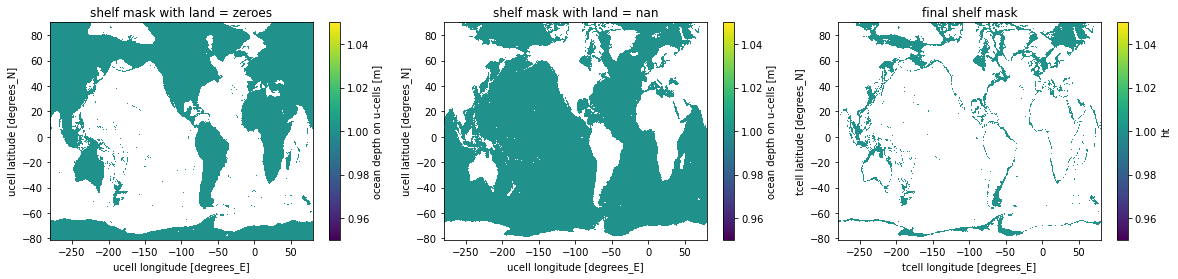

In [2]:
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
vars = ['ht', 'hu']
for f in range(2): # loop through the t- and u-grid
    field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').load()[vars[f]]
    above_1 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
                                             # the land here gets filled in with zeros as well
    above_1 = above_1.where(above_1 < 1000, drop=False) # remove all values bigger than 1000

    above_2 = field.where((field <= 1000) | field.isnull(), 0) # select only the shelf region and set all other values to zero
    above_2 = above_2.where(np.logical_or(above_2.isnull(), xr==0), 1) # replace all non-nan with 1 while keeping the land as nan
    above1000 = (above_1*above_2)

    if f == 0: above1000_tcells = above1000
    if f == 1: above1000_ucells = above1000
plt.figure(figsize=(20,4))
plt.subplot(1,3,1); above_1.plot(); plt.title('shelf mask with land = zeroes')
plt.subplot(1,3,2); above_2.plot(); plt.title('shelf mask with land = nan')
plt.subplot(1,3,3); above1000_tcells.plot(); plt.title('final shelf mask')
# above1000_tcells.to_netcdf('/g/data/e14/mv7494/IPOAnt_analysis/ACCESS-OM2-01_1000dbar_shelf_mask.nc')
b = field.fillna(0)

### First, loading in the four spatial patterns

In [3]:
%%time
db = 'local_cc_gdata_2sigma.db'; session = cc.database.create_session(db)
# ---------------------------------------------------------------------------------- #
time      = [  12,   24]  # [  30, 1613] = 2012-12-01 to 2017-04-01 just like SOSE   #
sel_lat    = [   0,  500]  # 81.1°S - 59.5°S                                         #
sel_lat2   = [   0,   53]  # 89.57°S - 60.37°S                                       #
sel_lon    = [   0, 3600]  # [1299, 2200] = 150°W - 60°W                             #
depth      = [  23,   75]  # 100 m to 1000 m                                         #
# ---------------------------------------------------------------------------------- #
exp        = ['01deg_jra55_ryf_IPOCtrl', '01deg_jra55_ryf_IPOPos',
              '01deg_jra55_ryf_IPONeg', '01deg_jra55_ryf_IPOInt',
              '01deg_jra55_ryf_IPO2sNeg']
var = ['tau_y', 'temp', 'salt']
var2 = ['tau_y', 'temp', 'salt']
unit_name = ['Meridional wind stress\n', 'Temperature\n', 'Salinity\n']
chunk_x = ['xu_ocean', 'xt_ocean', 'xt_ocean', 'xu_ocean'] # over which dimensions to chunk
chunk_y = ['yu_ocean', 'yt_ocean', 'yt_ocean', 'yu_ocean']
unit = ['(N m$^{-2}$)', '(°C)', '(psu)']
farbschema = [cm.cm.speed, 'RdBu_r', cm.cm.haline]
experiment_input = ['', 'positive_phase_fields', 'negative_phase_fields', 'interannual_run_fields', '2sigma_negative_phase_fields']

CPU times: user 14.9 ms, sys: 7.49 ms, total: 22.4 ms
Wall time: 53.5 ms


### Load in sea ice extent with the cosima cookbook

In [4]:
%%time
for e in [0,4]:
    aice_m = cc.querying.getvar(expt=exp[e], variable='aice_m', session=session, frequency='1 monthly',
                                 attrs={'cell_methods': 'time: mean'},
                                 start_time='2154-01-01 00:00:00', 
                                 end_time='2154-11-31 00:00:00',
                                 chunks = {'ni': '200MB', 'nj': '200MB'})
    if e == 0: aice_m_clim = aice_m
    if e == 4: aice_m_anom_IPO2sNeg = aice_m - aice_m_clim 
# Wall time: 1min 19s

CPU times: user 18.7 s, sys: 8.45 s, total: 27.1 s
Wall time: 1min 1s


In [5]:
%%time
aice_m_clim = aice_m_clim.mean('time').load()
aice_m_anom_IPO2sNeg = aice_m_anom_IPO2sNeg.mean('time').load()
# Wall time: 3.72 s

CPU times: user 1.47 s, sys: 575 ms, total: 2.04 s
Wall time: 5.55 s


In [6]:
sic_args = {
    "cice5": { #cice5 is part of ACCESS-OM2
        "expt": "01deg_jra55_ryf_IPOCtrl",
        "variable": "aice_m",
        "start_time": "1981-02-01",
        "end_time": "1991-01-01",
        "decode_coords": False
    }
}
geo_variables = {
    "cice5":['geolon_t', 'geolat_t'] ,
    "sis2": ['geolon', 'geolat']
}

geolon = cc.querying.getvar(sic_args['cice5']['expt'], geo_variables['cice5'][0], session, n = 1).load()
geolat = cc.querying.getvar(sic_args['cice5']['expt'], geo_variables['cice5'][1], session, n = 1).load()

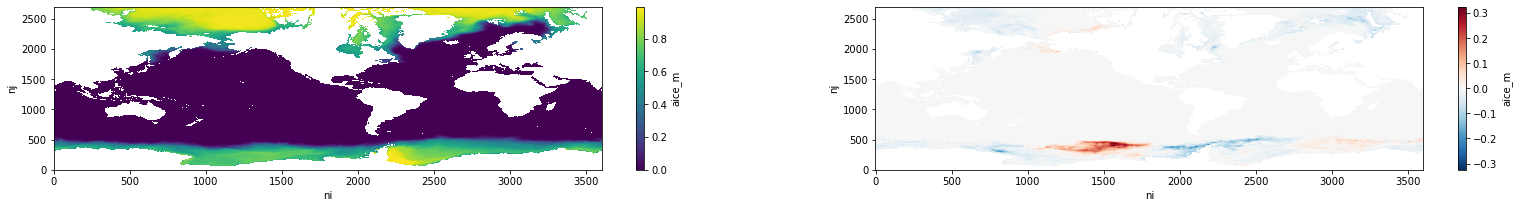

In [7]:

plt.figure(figsize=(27,3))
plt.subplot(1,2,1); aice_m_clim.plot(); plt.subplot(1,2,2); aice_m_anom_IPO2sNeg.plot()

### Plotting routine

In [8]:
%%time
import matplotlib.path as mpath 
def fancy_plot2(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 60), # longitude grid lines
                  ylocs= np.linspace(-45, -90, num=4)) # latitude grid lines
    ax.coastlines(); # add coast lines
    theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)

CPU times: user 6 µs, sys: 8 µs, total: 14 µs
Wall time: 23.1 µs


### Next, sea ice volume

In [9]:
%%time
# adapted from Pedro Colombo's sea ice calculations on github
from datetime import timedelta
area_t = cc.querying.getvar(exp[0], 'area_t', session, n=1)

for e in [0,1,2,4]: # loop through the simulations
    print(exp[e])

    # load in height of the sea ice
    hi_con   = cc.querying.getvar(exp[e], 'hi_m', session, frequency='1 monthly',
                                  attrs={'cell_methods': 'time: mean'},
                                  start_time='2154-07-01 00:00:00', end_time='2154-08-01 00:00:00', 
                                  chunks = {'ni': '200MB', 'nj': '200MB'})[:,sel_lat[0]:sel_lat[1],:]
    aice_con   = cc.querying.getvar(exp[e], 'aice_m', session, frequency='1 monthly',
                                  attrs={'cell_methods': 'time: mean'},
                                  start_time='2154-07-01 00:00:00', end_time='2154-08-01 00:00:00', 
                                  chunks = {'ni': '200MB', 'nj': '200MB'})[:,sel_lat[0]:sel_lat[1],:]


    

    # rename coordinates in t-grid (same as Pedro and Adele do)                            aice_con.coords['nj'] = area_t['yt_ocean'].values
#    aice_con              = aice_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'})); hi_con.coords['ni']   = area_t['xt_ocean'].values
#    hi_con.coords['nj']   = area_t['yt_ocean'].values;                             hi_con                = hi_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    # move time 12 hr forward to make sure it is in the correct month
    aice_con['time'] = aice_con.time.to_pandas() - timedelta(hours = 12)
    hi_con['time']   = hi_con.time.to_pandas() - timedelta(hours = 12)

    

    # Calculate sea ice volume, convert to km^3, select only West Antarctica and load into memory
    vi_con = (aice_con * (area_t * above1000_tcells).rename({'yt_ocean':'nj', 'xt_ocean':'ni'})[sel_lat[0]:sel_lat[1],:] * hi_con * 1e-9)

    vi_con = vi_con.sum(['nj']).mean('time').load()

    if e == 0: vi_con_clim = vi_con
    if e == 1: vi_con_IPOPOs_anom = (vi_con - vi_con_clim)
    if e == 2: vi_con_IPONeg_anom = (vi_con - vi_con_clim)
    if e == 4: vi_con_IPO2sNeg_anom = (vi_con - vi_con_clim)
print('---------------------------------------------------')
# Wall time: 17min 52s for one simulation

01deg_jra55_ryf_IPOCtrl
01deg_jra55_ryf_IPOPos
01deg_jra55_ryf_IPONeg
01deg_jra55_ryf_IPO2sNeg
---------------------------------------------------
CPU times: user 18.6 s, sys: 8.35 s, total: 26.9 s
Wall time: 50.9 s


01deg_jra55_ryf_IPO2sNeg
CPU times: user 4.79 s, sys: 1.4 s, total: 6.19 s
Wall time: 21.6 s


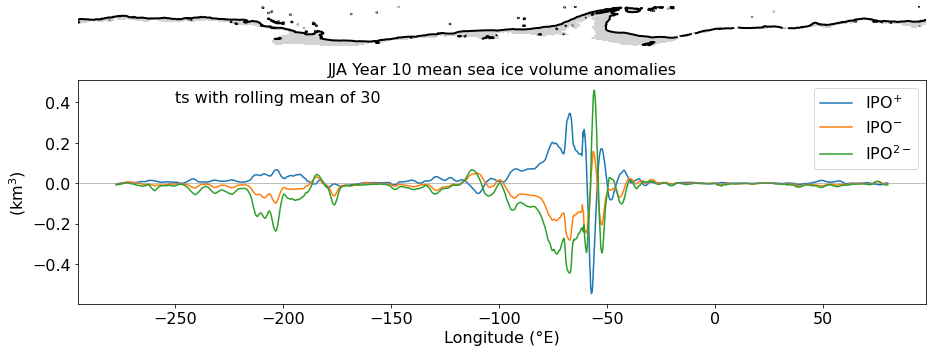

In [10]:
%%time
fig = plt.figure(figsize=(25,5),tight_layout=True)
gs = gridspec.GridSpec(2,2, width_ratios = [1,1], height_ratios = [.2,1]) 

ax1 = plt.subplot(gs[0,0])

# first panel ------------------------------------------------------------------- #
fieldAnt = field[sel_lat[0]:sel_lat[1],:] * above1000_ucells
leichtgrau = [.83, .83, .83]
p111 = fieldAnt.plot.contourf(linewidths=2, levels=np.linspace(0,1000,21), cmap='#D3D3D3', add_colorbar = False) # 1000 m isobath
p111 = field[sel_lat[0]:sel_lat[1],:].plot.contour(levels = [1000], linewidths=2, cmap='k') # 1000 m isobath

plt.xticks(fontsize=16); plt.yticks(fontsize=16)
ax1.set(xlabel=None); ax1.set(ylabel=None)
ax1.set_yticklabels([]); ax1.set_xticklabels([]); ax1.set(ylabel=None) # no y axis ticks and labels if panel is not on the far left
print(exp[e])
ax1.axis('off') # turn off axes

# second panel ------------------------------------------------------------------- #
ax1 = plt.subplot(gs[1,0])

# vi_con_clim.plot(label='IPOCtrl')
roll = 30 # over how many grid cells I take the rolling mean
vi_con_IPOPOs_anom.rolling(ni=30).mean('ni').plot(label='IPO$^{+}$')
vi_con_IPONeg_anom.rolling(ni=30).mean('ni').plot(label='IPO$^{-}$')
vi_con_IPO2sNeg_anom.rolling(ni=30).mean('ni').plot(label='IPO$^{2-}$')

plt.axhline(0, lw=.5, c='grey'); plt.legend(fontsize=16)
plt.ylabel('(km$^{3}$)', fontsize=16); plt.xlabel('Longitude (°E)', fontsize=16)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
plt.title('JJA Year 10 mean sea ice volume anomalies', fontsize=16)
plt.text(-250, 0.4, 'ts with rolling mean of '+ str(roll), fontsize=16)
# --- saving as 300 dpi .PNG image in specified folder ----------------------------------------------- #
plt.savefig(save + 'IPO_sea_ice_volume_time_series', #
        dpi=300, facecolor='w',                                                                    #
        edgecolor='w', orientation='landscape',                                                    #
        format=None, transparent=False, bbox_inches='tight',                                       #
        pad_inches=0.1, metadata=None)                                                             #
# --- end of script ---------------------------------------------------------------------------------- # 
# Wall time: 12min 44s

### Load in wind anomalies as overlay over the sea ice anomalies

In [20]:
%%time
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
base        = '/g/data/e14/mv7494/IPOAnt_input/'
exp         = ['01deg_jra55_ryf_IPOCtrl', '01deg_jra55_ryf_IPOPos','01deg_jra55_ryf_IPONeg', '01deg_jra55_ryf_IPOInt', '01deg_jra55_ryf_IPO2sNeg']
in_location = ['', 'positive_phase_fields', 'negative_phase_fields', 'interannual_run_fields', '2sigma_negative_phase_fields']
suffix      = ['IPOCtrl', 'IPO$^{+}$', 'IPO$^{-}$', 'Interannual run', 'IPO$^{2-}$']
var  = [   'u_10',    'v_10']
var2 = ['uas_10m', 'vas_10m']   
var3 = [    'uas',     'vas'] 
limiten = [-.4,.4] # limits of colour bars

# ---------------------------------------------------------------------------------- #
sel_lat    = [   0,  500]  # 81.1°S - 59.5°S                                         #
sel_lon    = [   0, 3600]  # [1299, 2200] = 150°W - 60°W                             #
Wedell_lat = [   0,  270]  # Wedell Sea only                                         #
Wedell_lon = [2150, 2600] # Wedell Sea only                                          #
depth      = [  23,   75]  # 100 m to 1000 m                                         #
# ---------------------------------------------------------------------------------- #

for e in [1,2,4]:                   
    for i in range(2):
    
        if i == 0: variabel = 'Zonal'
        if i == 1: variabel = 'Meridional'
        print(exp[e] + ' ' + var2[i])
        RYF_field   = xr.open_dataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.'+var[i]+'.1990_1991.nc',
                                    chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})[var2[i]][0,:,:]
        if e in [1,2]: input_field = xr.open_dataset(base + in_location[e] + '/RYF.'+var2[i]+'.1990_1991.nc')[var2[i]][0,:,:]
        else:          input_field = xr.open_dataset(base + in_location[e] + '/RYF.'+var2[i]+'.1990_1991.nc')[var2[i]][0,:,:]
        anom = (input_field - RYF_field)

        if e == 1 and i == 0: u_10_IPOPos = anom
        if e == 1 and i == 1: v_10_IPOPos = anom
        if e == 2 and i == 0: u_10_IPONeg = anom
        if e == 2 and i == 1: v_10_IPONeg = anom
        if e == 4 and i == 0: u_10_IPO2sNeg = anom
        if e == 4 and i == 1: v_10_IPO2sNeg = anom

01deg_jra55_ryf_IPOPos uas_10m
01deg_jra55_ryf_IPOPos vas_10m
01deg_jra55_ryf_IPONeg uas_10m
01deg_jra55_ryf_IPONeg vas_10m
01deg_jra55_ryf_IPO2sNeg uas_10m
01deg_jra55_ryf_IPO2sNeg vas_10m
CPU times: user 262 ms, sys: 49.3 ms, total: 311 ms
Wall time: 271 ms


### Next, sea ice volume anomalies as time series

In [11]:
%%time
# adapted from Pedro Colombo's sea ice calculations on github
from datetime import timedelta
area_t = cc.querying.getvar(exp[0], 'area_t', session, n=1)

for e in [0,1,2,4]: # loop through the simulations
    print(exp[e])

    # load in height of the sea ice
    hi_con   = cc.querying.getvar(exp[e], 'hi_m', session, frequency='1 monthly',
                                  attrs={'cell_methods': 'time: mean'},
                                  start_time='2151-07-01 00:00:00', end_time='2154-08-01 00:00:00', 
                                  chunks = {'ni': '200MB', 'nj': '200MB'})[:,sel_lat[0]:sel_lat[1],:]
    aice_con   = cc.querying.getvar(exp[e], 'aice_m', session, frequency='1 monthly',
                                  attrs={'cell_methods': 'time: mean'},
                                  start_time='2151-07-01 00:00:00', end_time='2154-08-01 00:00:00', 
                                  chunks = {'ni': '200MB', 'nj': '200MB'})[:,sel_lat[0]:sel_lat[1],:]
    
    # rename coordinates in t-grid (same as Pedro and Adele do)                            aice_con.coords['nj'] = area_t['yt_ocean'].values
#    aice_con              = aice_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'})); hi_con.coords['ni']   = area_t['xt_ocean'].values
#    hi_con.coords['nj']   = area_t['yt_ocean'].values;                             hi_con                = hi_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    # move time 12 hr forward to make sure it is in the correct month
    aice_con['time'] = aice_con.time.to_pandas() - timedelta(hours = 12)
    hi_con['time']   = hi_con.time.to_pandas() - timedelta(hours = 12)

    

    # Calculate sea ice volume, convert to km^3, select only West Antarctica and load into memory
    vi_con = (aice_con * (area_t * above1000_tcells).rename({'yt_ocean':'nj', 'xt_ocean':'ni'})[sel_lat[0]:sel_lat[1],:] * hi_con * 1e-9)

    # only select the winter season (JJA down in Antarctica)
    # ['DJF', 'JJA', 'MAM', 'SON']
    vi_con = vi_con.groupby('time.season').mean('time')[1,:,:].load()

    if e == 0: vi_con_clim = vi_con
    if e == 1: vi_con_IPOPOs_anom = (vi_con - vi_con_clim)
    if e == 2: vi_con_IPONeg_anom = (vi_con - vi_con_clim)
    if e == 4: vi_con_IPO2sNeg_anom = (vi_con - vi_con_clim)
print('---------------------------------------------------')
# Wall time: 9 min 14s

01deg_jra55_ryf_IPOCtrl
01deg_jra55_ryf_IPOPos
01deg_jra55_ryf_IPONeg
01deg_jra55_ryf_IPO2sNeg
---------------------------------------------------
CPU times: user 3min 20s, sys: 1min 39s, total: 5min
Wall time: 9min 33s


Text(0.5, 0.98, 'Sea ice volume anomalies, year 8-10 (km$^{3}$)')

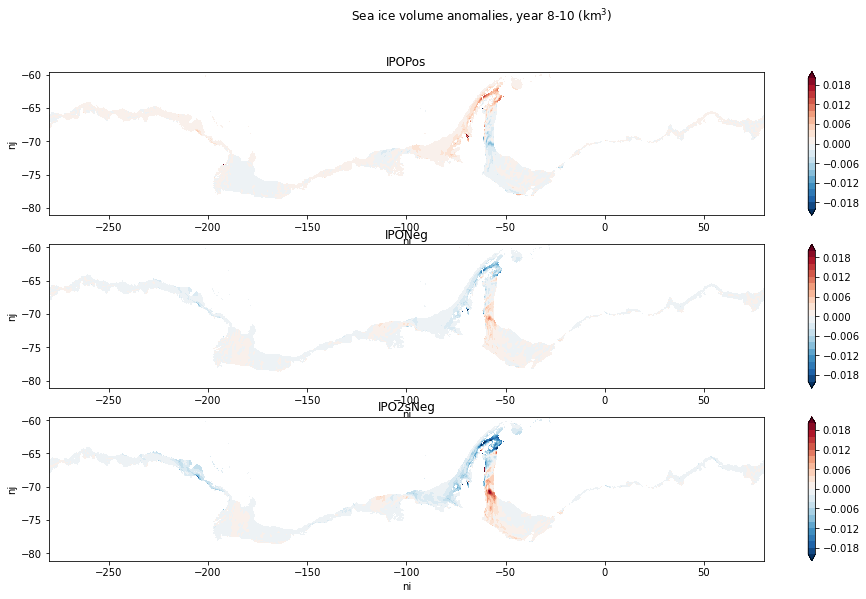

In [12]:
plt.figure(figsize=(16,9))
plt.subplot(3,1,1); vi_con_IPOPOs_anom.plot(levels=np.linspace(-.02,.02,21)); plt.title('IPOPos')
plt.subplot(3,1,2); vi_con_IPONeg_anom.plot(levels=np.linspace(-.02,.02,21)); plt.title('IPONeg')
plt.subplot(3,1,3); vi_con_IPO2sNeg_anom.plot(levels=np.linspace(-.02,.02,21)); plt.title('IPO2sNeg')
plt.suptitle('Sea ice volume anomalies, year 8-10 (km$^{3}$)')

### Zooming into the Weddell and Ross Sea regions

sea ice volume anoms for 01deg_jra55_ryf_IPOPos
sea ice volume anoms for 01deg_jra55_ryf_IPONeg
sea ice volume anoms for 01deg_jra55_ryf_IPO2sNeg
CPU times: user 7min 32s, sys: 2min, total: 9min 33s
Wall time: 7min 25s


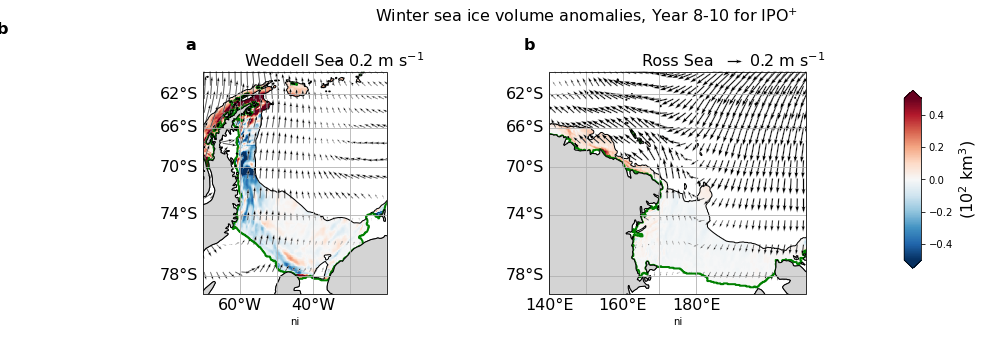

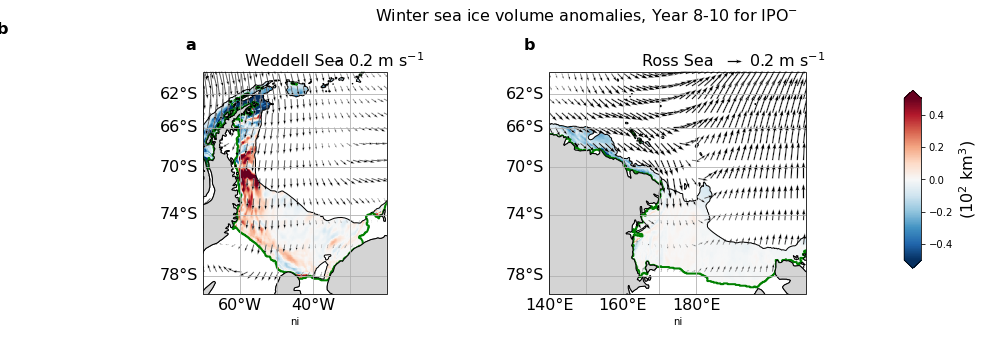

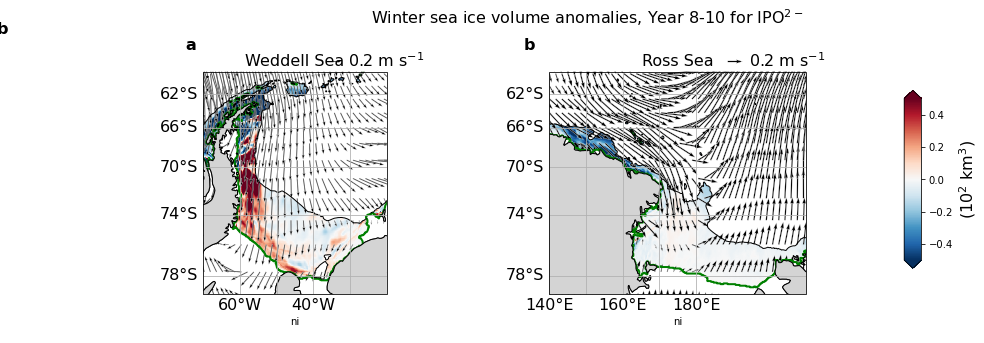

In [32]:
%%time
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]],
    'sig0_bins': [27.92, 27.81, 27.81, 28]}
base        = '/g/data/e14/mv7494/IPOAnt_input/'
exp         = ['01deg_jra55_ryf_IPOCtrl', '01deg_jra55_ryf_IPOPos','01deg_jra55_ryf_IPONeg', '01deg_jra55_ryf_IPOInt', '01deg_jra55_ryf_IPO2sNeg']
in_location = ['', 'positive_phase_fields', 'negative_phase_fields', 'interannual_run_fields', '2sigma_negative_phase_fields']
suffix      = ['IPOCtrl', 'IPO$^{+}$', 'IPO$^{-}$', 'Interannual run', 'IPO$^{2-}$']
var  = [   'u_10',    'v_10']
var2 = ['uas_10m', 'vas_10m']   
var3 = [    'uas',     'vas'] 
limiten = [-.5,.5] # limits of colour bars (km$^{3}$)

# ---------------------------------------------------------------------------------- #
sel_lat    = [   0,  500]  # 81.1°S - 59.5°S                                         #
sel_lon    = [   0, 3600]  # [1299, 2200] = 150°W - 60°W                             #
Wedell_lat = [   0,  270]  # Wedell Sea only                                         #
Wedell_lon = [2150, 2600] # Wedell Sea only                                          #
depth      = [  23,   75]  # 100 m to 1000 m                                         #
# ---------------------------------------------------------------------------------- #

for e in [1,2,4]: #[1,2,4] 
    if e == 1: 
        data = vi_con_IPOPOs_anom * 1e2 # write exponent into colour bar
        u_wind = u_10_IPOPos; v_wind = v_10_IPOPos # wind anomalies for overlay
    if e == 2: 
        data = vi_con_IPONeg_anom * 1e2 
        u_wind = u_10_IPONeg; v_wind = v_10_IPONeg
    if e == 4: 
        data = vi_con_IPO2sNeg_anom * 1e2
        u_wind = u_10_IPO2sNeg; v_wind = v_10_IPO2sNeg
        
    fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')
    gs = gridspec.GridSpec(1,2); proj = ccrs.PlateCarree()

    print('sea ice volume anoms for ' + exp[e])
    
    for a, area_text in enumerate(DSW_region['name']):
        if a in [1, 2]: continue
        if a == 0: # Weddell Sea
            minlon, maxlon, minlat, maxlat = [-70, -20, -79, -59]
            letter = string.ascii_lowercase[0] + ') '
        elif a == 3: # Ross Sea
            minlon, maxlon, minlat, maxlat = [140, 210, -79, -59]
            letter = string.ascii_lowercase[1] + ') '
        
        if a == 0:
            ax = plt.subplot(2, 6, (1, 2), projection=ccrs.Mercator(
                min_latitude=-85, max_latitude=-50,
                latitude_true_scale=-70))
            ax.text(-.1, 1.1,string.ascii_lowercase[0], transform=ax.transAxes, size=16, weight='bold') # c, d, e
        elif a == 3:
            ax = plt.subplot(2, 6, (3, 5), projection=ccrs.Mercator(
                central_longitude=180, min_latitude=-85, max_latitude=-50,
                latitude_true_scale=-70))
            ax.text(-.1, 1.1,string.ascii_lowercase[1], transform=ax.transAxes, size=16, weight='bold') # c, d, e
            
    
        ax.set_extent([minlon, maxlon, minlat, maxlat], proj)
        gl = ax.gridlines(draw_labels=False, crs=proj, alpha=1)
        gl.left_labels = True
        gl.ylabel_style = {'size': 16}
        # gl.bottom_labels = True
        if area_text == 'Weddell':
            gl.xlocator = mticker.FixedLocator(np.arange(-70, -10, 10))
            ax.set_xticks(np.arange(-60, -20, 20), crs=proj); plt.xticks(fontsize=16); 
            # ax.set_yticks(np.arange(-62, -66, -70, -74, -78), crs=proj); plt.yticks(fontsize=16);         
            
            plt.yticks(fontsize=16)
        elif area_text == 'Ross':
            gl.xlocator = mticker.FixedLocator(np.arange(140, 200, 10))
            ax.set_xticks(np.arange(140, 200, 20), crs=proj); plt.xticks(fontsize=16); 
            ax.set_yticklabels([]); ax.set(ylabel=None) 
        ax.xaxis.set_major_formatter(LongitudeFormatter(
            dateline_direction_label=True))
        ax.tick_params(length=0)
        gl.ylocator = mticker.FixedLocator(np.arange(-78, -50, 4))
    
        ax.coastlines(resolution='50m')
    
        plt.contour(b.xu_ocean, b.yu_ocean, b, levels=[1], colors='g', linewidths=2, transform=proj)
    
        ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
        plt.contour(field.xu_ocean, field.yu_ocean, field, levels=[1000], colors='k', linewidths=1, transform=proj)
    
        p1   = data.plot.pcolormesh(vmin=limiten[0],vmax=limiten[1], add_colorbar=False, cmap = 'RdBu_r', transform=ccrs.PlateCarree())


        # adding wind arrows
        # specifics for the wind speed arrows
        X = u_wind.longitude; Y = v_wind.latitude
        U = u_wind; V = v_wind
        # widths = np.linspace(-.0001, .0001, X.size)
        # Add the wind stress arrows, only plotting every 30th data point.
        abstand = 3 # select every n-th arrow
        Q = plt.quiver(to_np(X[::abstand]),   to_np(Y[::abstand]), 
                   to_np(U[::abstand, ::abstand]), to_np(V[::abstand, ::abstand]), 
                   scale=3, minshaft = 2, scale_units='height', transform=ccrs.PlateCarree(), width=.005, linewidths=.3, edgecolor=('w')) 
                              # minshaft = select minimum sized arrow (i.e., only those larger than 2)
        # reference key on the map
                            # x0,   y0, scale
        qk = plt.quiverkey(Q, .75, 1.05, .2, r'0.2 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) 

        # plotting here
        # karte = (vi_con_IPOPOs_anom.mean('st_ocean')*mask_DSW[a,:,:]); karte = karte.where(karte != 0) # multiply with mask and set all zeros to NaN
    #    karte = (above1000_tcells); karte = karte.where(karte != 0) # multiply with mask and set all zeros to NaN
    #    p1   = vi_con_IPOPOs_anom.plot.pcolormesh(vmin=limiten[0],vmax=limiten[1], add_colorbar=False, cmap = 'RdBu_r', transform=ccrs.PlateCarree())
    
        if a == 0: plt.title('Weddell Sea', fontsize=16)
        if a == 3: plt.title('Ross Sea', fontsize=16)
    
        ax.set_yticklabels([]); ax.set(ylabel=None) 
        if a == 3:    
            pos = ax.get_position()
            cax = plt.axes([pos.xmax+.085, pos.ymin+0.04,
                            0.015, .8*(pos.ymax-pos.ymin)])
            cb = plt.colorbar(p1, cax=cax, orientation='vertical', extend='both')
            cb.ax.set_ylabel('(10$^{2}$ km$^{3}$)', fontsize=16)
    
        if a == 3: ax.text(-.1, 1.15,string.ascii_lowercase[1], transform=ax1.transAxes, size=16, weight='bold') # c, d, e
    
    plt.suptitle('Winter sea ice volume anomalies, Year 8-10 for ' + suffix[e], fontsize=16)
    # Wall time: 2min 10s

    # --- saving as 300 dpi .PNG image in specified folder ----------------------------------------------- #
    plt.savefig(save + 'IPO_sea_ice_volume_zoom_maps', #
            dpi=300, facecolor='w',                                                                    #
            edgecolor='w', orientation='landscape',                                                    #
            format=None, transparent=False, bbox_inches='tight',                                       #
            pad_inches=0.1, metadata=None)                                                             #
    # --- end of script ---------------------------------------------------------------------------------- # 
# Wall time: 7min 17s

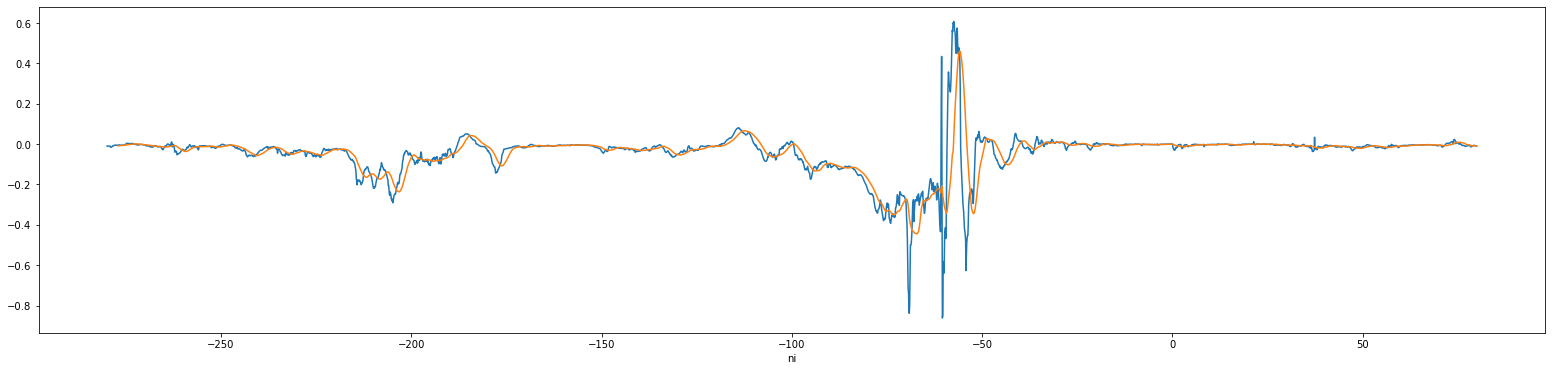

In [79]:
plt.figure(figsize=(27,6))
vi_con_IPO2sNeg_anom.plot()
vi_con_IPO2sNeg_anom.rolling(ni=30).mean('ni').plot()

CPU times: user 13.3 s, sys: 1.44 s, total: 14.7 s
Wall time: 13.3 s


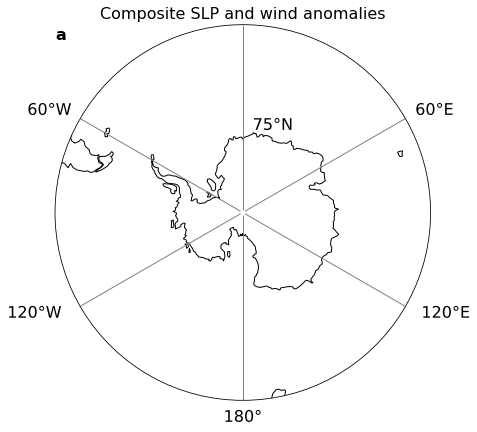

In [ ]:
    # Add the wind stress arrows, only plotting every 30th data point.
#    X = uas.lon; Y = uas.lat; U = uas; V = vas; abstand = 7 # specifics for the wind speed arrows

    # --------------------------------------------------------------------------------------------------------------------------- #
#    abstand = 7 # plot every n-th wind arrow
#    skala = 20
#    Q = plt.quiver(to_np(X[::abstand]),   to_np(Y[::abstand]), to_np(U[::abstand, ::abstand]), to_np(V[::abstand, ::abstand]), 
#                   scale=skala, minshaft = 2, scale_units='height', transform=ccrs.PlateCarree(), width=.005, linewidths=.5, edgecolor=('w')) 
#                          # minshaft = select minimum sized arrow (i.e., only those larger than 2)
    # --------------------------------------------------------------------------------------------------------------------------- #

    if f == 0: # add reference key,  x0,   y0 of quiver key
#        qk = plt.quiverkey(Q,        .1,    0, 1, r'1 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) # add quiver if first subpanel

        # add labels
        xlab =    [  1.01,    1.04,     .5,   -.055,  -.015,    .58] # x-position of labels
        ylab =    [   .76,     .22,  -.057,     .22,    .76,    .72] # y-position of labels
        txt_lab = ['60°E', '120°E', '180°', '120°W', '60°W', '75°N'] # label text

        # loop through the 7 labels and surround with white space for higher visibility
        for l in range(len(txt_lab)):
            ax1.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                    fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 


    ax1.text(0, .96, string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    fancy_plot(ax1); plt.title(stitel[f], fontsize=16)

In [ ]:
#    if f == 0: plt.text(-180,50,'El Niño', fontsize=20, ha='center', va='center', fontweight='bold', transform=ccrs.PlateCarree()) # x0, y0
#    if f == 1: plt.text(-180,50,'La Niña', fontsize=20, ha='center', va='center', fontweight='bold', transform=ccrs.PlateCarree()) # x0, y0
    
    if f in [1]: # add colour bar 
        cax = fig.add_axes([.36, 0.05, .3, .02]) # x0, y0, width, height
        cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal'); 
        cb.set_label(label='(hPa)', size=16); cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
        cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p111)            

In [ ]:
# --- saving as 300 dpi .PNG image in specified folder ----------------------------------------------- #
# plt.savefig(save + 'ENSO_composite_patterns_SLP_winds_Arctic', #
#             dpi=300, facecolor='w',                                                                    #
#             edgecolor='w', orientation='landscape',                                                    #
#             format=None, transparent=False, bbox_inches='tight',                                       #
#             pad_inches=0.1, metadata=None)                                                             #
# # --- end of script ---------------------------------------------------------------------------------- # 
# # Wall time: 1min 21s

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22677085923136 and this is thread id 22674099021568.
Exception closing connection <sqlite3.Connection object at 0x149de9edf8a0>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/b

tau_y IPOPos
temp IPOPos
salt IPOPos
tau_y IPONeg
temp IPONeg
salt IPONeg
tau_y IPOInt
temp IPOInt
salt IPOInt
tau_y IPO2sNeg
temp IPO2sNeg
salt IPO2sNeg
CPU times: user 3min 31s, sys: 41.1 s, total: 4min 12s
Wall time: 10min 54s


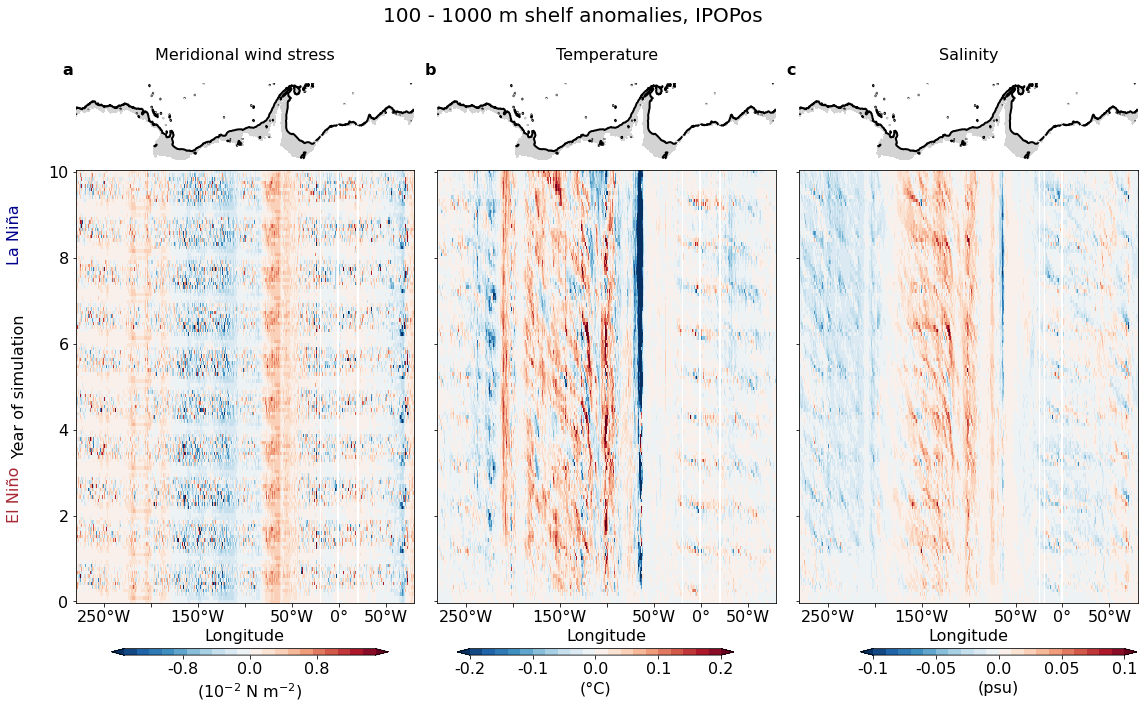

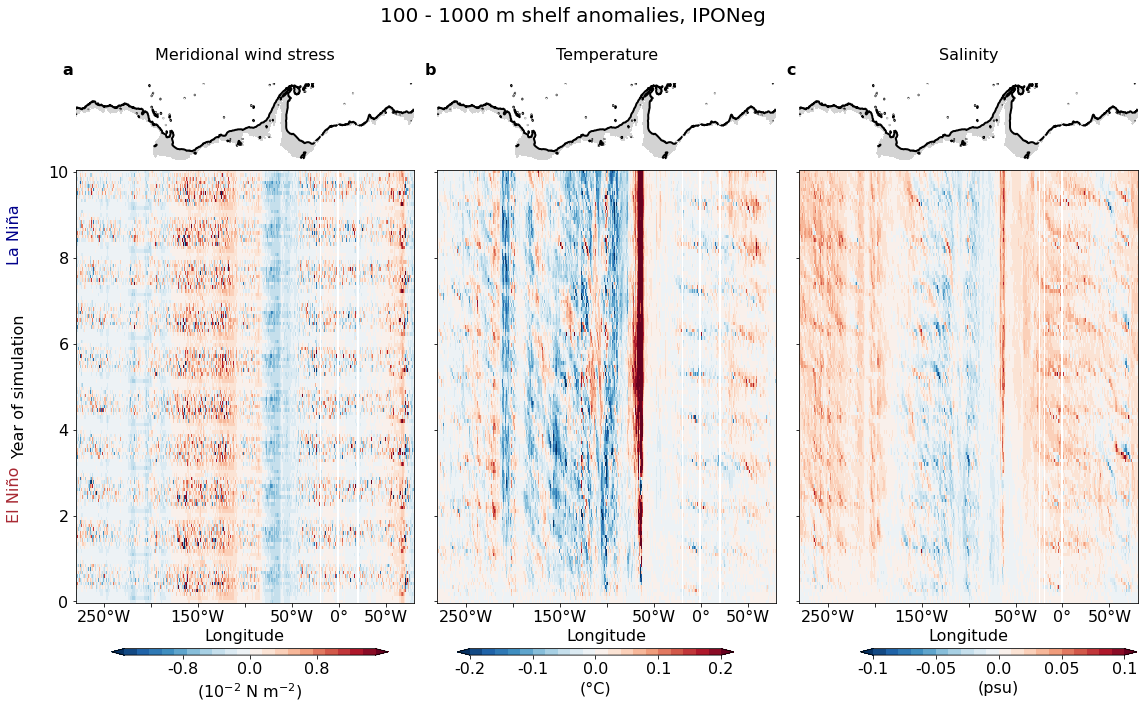

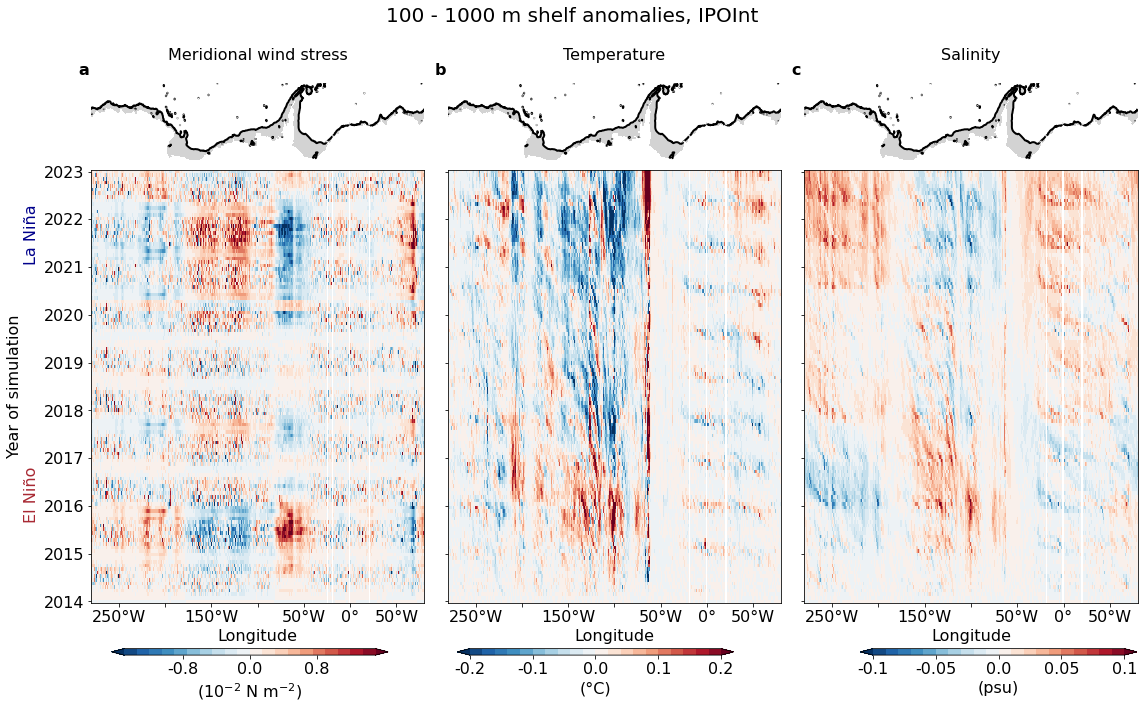

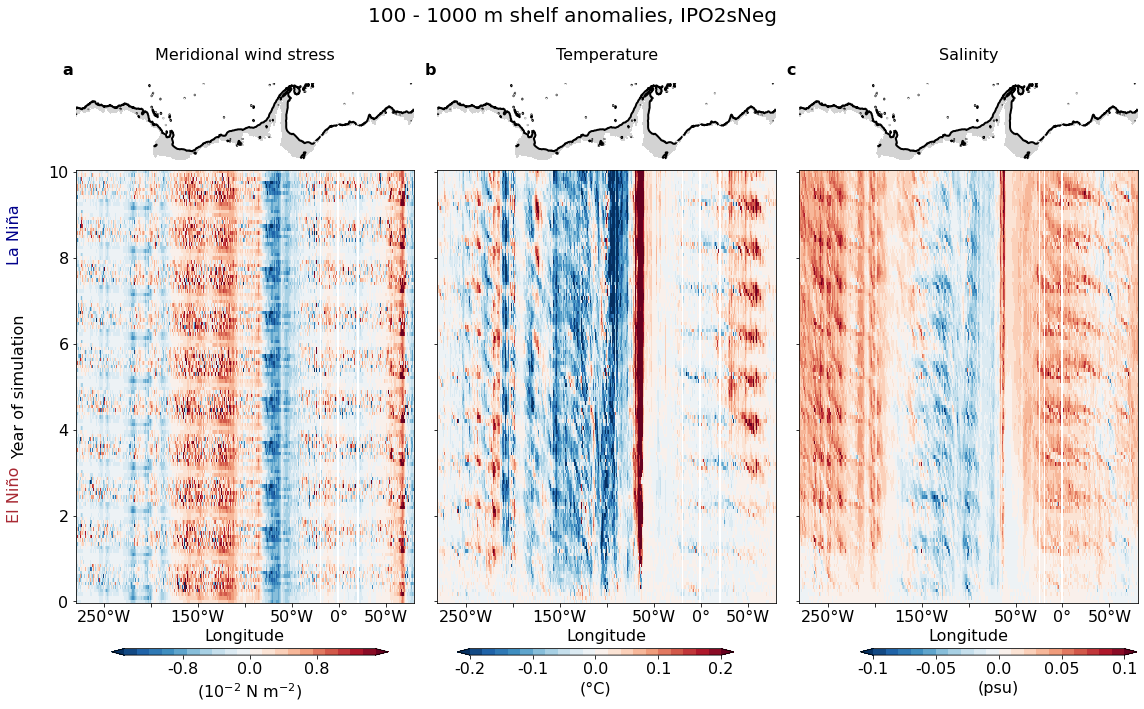

In [ ]:
# plot a quick figure
for e in [3]:#[1,2,3,4]: # loop through the four different experiments
    fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')
    gs = gridspec.GridSpec(2,3, width_ratios = [1,1,1], height_ratios = [.2,1]) 
    gs.update(hspace=0) # set the spacing between axes.
    
    for v in range(3): # loop through the four variables (v-wind, slp, temp, salt)
        data = cc.querying.getvar(expt=exp[e], variable=var[v], session=session, frequency='1 monthly', attrs={'cell_methods': 'time: mean'},
                                            chunks = {chunk_y[v]: '200MB', chunk_x[v]: '200MB'}, decode_times=False)#[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
        data_clim = cc.querying.getvar(expt='01deg_jra55_ryf_IPOCtrl', variable=var[v], session=session, frequency='1 monthly', attrs={'cell_methods': 'time: mean'},
                                            chunks = {chunk_y[v]: '200MB', chunk_x[v]: '200MB'}, decode_times=False)#[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
        if v in [0]: # take mean over the latitude for wind stress
            data_anom = ((data - data_clim) * above1000_ucells)[:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean(chunk_y[v], skipna=True)
        if v in [1, 2]: # same but for temp & salt fields
            data_anom = ((data - data_clim) * above1000_tcells)[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean([chunk_y[v], 'st_ocean'], skipna=True)

        print(var[v], exp[e][16:])
        if v == 0: ticks = np.linspace(-1.5, 1.5, 21)
        if v == 1: ticks = np.linspace( -.2,  .2, 21)
        if v == 2: ticks = np.linspace( -.1,  .1, 21)
        # Wall time: 2min 12 s

        if e in [3]: time_yr = np.linspace(2014, 2023,120) # replace time axis with year index for 1-10 years of simulation
        else:        time_yr = np.linspace(0, 10, 120) # replace time axis with year index for 1-10 years of simulation
        data_anom = data_anom.assign_coords(time=('time', time_yr)) # so that my y-axis goes from 1-10 years


        # first set of panels ------------------------------------------------------------------- #
        ax1 = plt.subplot(gs[0,v])
        fieldAnt = field[sel_lat[0]:sel_lat[1],:] * above1000_ucells

        leichtgrau = [.83, .83, .83]
        p111 = fieldAnt.plot.contourf(linewidths=2, levels=np.linspace(0,1000,21), cmap='#D3D3D3', add_colorbar = False) # 1000 m isobath
        p111 = field[sel_lat[0]:sel_lat[1],:].plot.contour(levels = [1000], linewidths=2, cmap='k') # 1000 m isobath
        
#        plt.plot([-197,-197], [-60, -81.09], color = 'grey', lw=.75) # vertical line
#        plt.plot([-183,-183], [-60, -81.09], color = 'grey', lw=.75)
#        plt.plot([-60,-60], [-60, -81.09], color = 'grey', lw=.75)
#        plt.plot([-50,-50], [-60, -81.09], color = 'grey', lw=.75)
        
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        ax1.set(xlabel=None); ax1.set(ylabel=None)
        
        plt.title(unit_name[v], fontsize=16)
        if v in [1,2,3]: ax1.set_yticklabels([]); ax1.set(ylabel=None) # no y axis ticks and labels if panel is not on the far left
            
        ax1.text(-.038, 1.1,string.ascii_lowercase[v], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    

        #
       # ax1.set_facecolor('green')
        ax1.axis('off') # turn off axes
        
        # second set of panels -------------------------------------------------------------------- #
        ax1 = plt.subplot(gs[1,v])

        if v == 0: p1 = (data_anom*1e2).plot(cmap='RdBu_r', levels=ticks, add_colorbar=False)
        if v == 1: p2 = data_anom.plot(cmap='RdBu_r', levels=ticks, add_colorbar=False)
        if v == 2: p3 = data_anom.plot(cmap='RdBu_r', levels=ticks, add_colorbar=False)
            
        plt.suptitle('100 - 1000 m shelf anomalies, ' + exp[e][16:], fontsize=20, y=1)
        # ---------------------------------------------------------------------------------------- #
        plt.locator_params(axis='y', nbins=10)
        
        #        ax1.set_yticks([2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154]) # custom x ticks
        
        # lines indicating Ross and Weddell Sea
#        plt.axvline(-197, c='grey', lw=.75); plt.axvline(-183, c='grey', lw=.75) # Ross Sea
#        plt.axvline(-60, c='grey', lw=.75); plt.axvline(-50, c='grey', lw=.75) # Weddell Sea 
        
    #    ax1.set_xticklabels([]); ax1.set(xlabel=None) # no x axis ticks and labels
        
        # replace longitude and latitude values -> e.g., from -60°N to 60°S
        labels_x = [item.get_text() for item in ax1.get_xticklabels()]; labels_x = ['', '250°W', '', '150°W', '', '50°W', '0°', '50°W']
      #  labels_y = [item.get_text() for item in ax1.get_yticklabels()]; labels_y = ['', '80°S', '70°S', '60°S']
        ax1.set_xticklabels(labels_x); # ax1.set_yticklabels(labels_y)
        
        ax1.set_ylabel('Year of simulation\n', fontsize=16); ax1.set_xlabel('Longitude', fontsize=16)
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        if v in [1,2,3]: ax1.set_yticklabels([]); ax1.set(ylabel=None) # no y axis ticks and labels if panel is not on the far left
    #    ax1.text(-.038, 1.05, string.ascii_lowercase[v], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

        if v == 0:
            ax1.text(-.18,.85, 'La Niña', transform=ax1.transAxes, size=16, 
                     c = 'darkblue', ha='center', va='center', zorder=0, rotation=90) # bold letter a at the top
            ax1.text(-.18,.25, 'El Niño', transform=ax1.transAxes, size=16, 
                     c = rotblau[3], ha='center', va='center', zorder=0, rotation=90) # bold letter a at the top

    # add colour bars
    cax = fig.add_axes([.1, .0, .24, .01]) # position: [x0, y0, width, height]
    from matplotlib.ticker import FuncFormatter
    fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
    cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal', format=FuncFormatter(fmt)); 
    cb_txt = cb.set_label(label='(10$^{-2}$ N m$^{-2}$)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks()

    cax = fig.add_axes([.4, .0, .24, .01]) # position: [x0, y0, width, height]
    from matplotlib.ticker import FuncFormatter
    fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
    cb = plt.colorbar(p2, cax = cax, shrink=.5, orientation='horizontal', format=FuncFormatter(fmt)); 
    cb_txt = cb.set_label(label='(°C)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks()

    cax = fig.add_axes([.75, .0, .24, .01]) # position: [x0, y0, width, height]
    from matplotlib.ticker import FuncFormatter
    fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
    cb = plt.colorbar(p3, cax = cax, shrink=.5, orientation='horizontal', format=FuncFormatter(fmt)); 
    cb_txt = cb.set_label(label='(psu)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks()

#     plt.yticks([2145,2146,2147,2148,2149,2150,2151,2152,2153,2154])
    plt.savefig(save + 'quick_hovmoeller_shelf_anomalies_'+exp[e],
                dpi=300, facecolor='w',edgecolor='w', orientation='landscape', papertype=None, format=None,
                transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)                              #
# --- end of script ------------------------------------------------------------------------------------------- # 
# Wall time: 10min 56s

In [31]:
data_anom

<xarray.DataArray (time: 120, xt_ocean: 3600)>
dask.array<mean_agg-aggregate, shape=(120, 3600), dtype=float32, chunksize=(3, 450), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * time      (time) float64 0.0 0.08403 0.1681 0.2521 ... 9.832 9.916 10.0

In [10]:
%%time
a = (slp_timeseries*slp_spatial)[:,sel_lat2[0]:sel_lat2[1],:]#.to_netcdf('/g/data/e14/mv7494/IPOAnt_input/spatial_anomalies_in_time_psl.nc')

CPU times: user 35.6 ms, sys: 2.33 ms, total: 37.9 ms
Wall time: 35.4 ms


In [14]:
a[0:100,:,:].mean('lat').plot()

2024-09-25 01:49:52,629 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.30 GiB -- Worker memory limit: 8.97 GiB
2024-09-25 01:49:52,727 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.49 GiB -- Worker memory limit: 8.97 GiB
2024-09-25 01:49:52,827 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

KilledWorker: ("('getitem-mean_chunk-mul-mean_agg-aggregate-6f79fed3456e3775e0e3ee64e420de88', 0, 0)", <WorkerState 'tcp://127.0.0.1:44071', name: 4, status: closed, memory: 0, processing: 1>)

### Checking various anomalies

### Using Cosima cookbook to load in the data

In [19]:
%%time
db = 'local_cc_gdata_2sigma.db'; session = cc.database.create_session(db)
# ---------------------------------------------------------------------------------- #
time      = [  12,   24]  # [  30, 1613] = 2012-12-01 to 2017-04-01 just like SOSE   #
sel_lat    = [   0,  500]  # 81.1°S - 59.5°S                                         #
sel_lat2   = [   0,   53]  # 89.57°S - 60.37°S                                       #
sel_lon    = [   0, 3600]  # [1299, 2200] = 150°W - 60°W                             #
depth      = [  23,   75]  # 100 m to 1000 m                                         #
# ---------------------------------------------------------------------------------- #
exp        = ['01deg_jra55_ryf_IPOCtrl', '01deg_jra55_ryf_IPOPos',
              '01deg_jra55_ryf_IPONeg', '01deg_jra55_ryf_IPOInt',
              '01deg_jra55_ryf_IPO2sNeg']
var = ['vas_10m', 'psl', 'temp', 'salt']
var2 = ['v_10', 'slp', 'temp', 'salt']
unit_name = ['Meridional wind', 'Sea level pressure', 'Temperature', 'Salinity']
chunk_x = ['longitude', 'longitude', 'xt_ocean', 'xt_ocean', 'xu_ocean'] # over which dimensions to chunk
chunk_y = ['latitude', 'latitude', 'yt_ocean', 'yt_ocean', 'yu_ocean']
unit = [' (m s$^{-1}$)', ' (hPa)', ' (°C)', ' (psu)', ' (N m$^{-2}$)']
farbschema = ['RdBu_r', cm.cm.haline]
experiment_input = ['', 'positive_phase_fields', 'negative_phase_fields', 'interannual_run_fields', '2sigma_negative_phase_fields']

# plot a quick figure
for e in [3]:#,2,3,4]: # loop through the four different experiments
#    fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')
    gs = gridspec.GridSpec(2,4, width_ratios = [1,1,1,1], height_ratios = [1,.2]) 
    
    for v in [1]:#,1,2,3]: # loop through the four variables (v-wind, slp, temp, salt)
        print(var[v], exp[e][16:])

        if v == 0: 
            ticks = np.linspace(-.2,.2,21) # ticks for meridional wind anomalies on the shelf
        if v == 1: 
            ticks = np.linspace(-60,60,21) # ticks for sea level pressure anomalies on the shelf
        if v == 2: 
            ticks = np.linspace(-.25,.25,21) # ticks for temperature anomalies on the shelf
        if v == 3: 
            ticks = np.linspace(-.05,.05,21) # ticks for salinity anomalies on the shelf
        
        # loading in the data and the climatological data
        if v in [0,1] and e in [0,1,2]: # if the data is from JRA55-do
            data = xr.open_mfdataset('/g/data/e14/mv7494/IPOAnt_input/'+experiment_input[e]+'/' + 'RYF.'+var[v]+'.1990_1991.nc',
                                     chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'}, decode_times = True)[var[v]][:,sel_lat2[0]:sel_lat2[1],:] 
            data_clim = xr.open_mfdataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.'+var2[v]+'.1990_1991.nc',
                                          chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'}, decode_times = True)[var[v]][:,sel_lat2[0]:sel_lat2[1],:] 
            data_anom = (data - data_clim)
            
        if v in [0,1] and e in [3]: # if the data is from JRA55-do
            data = xr.open_mfdataset('/g/data/e14/mv7494/IPOAnt_input/'+experiment_input[e]+'/yr*/' + 'RYF.'+var[v]+'.1990_1991.nc',
                                     chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'}, decode_times = True)[var[v]][:,sel_lat2[0]:sel_lat2[1],:] 
            data_clim = xr.open_mfdataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.'+var2[v]+'.1990_1991.nc',
                                          chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'}, decode_times = True)[var[v]][:,sel_lat2[0]:sel_lat2[1],:] 
            data_anom = (data - data_clim)
data_anom
            

psl IPOInt


ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [ ]:
            lengh_of_sim = 10 # ten years
            # https://stackoverflow.com/questions/53345442/about-changing-longitude-array-from-0-360-to-180-to-180-with-python-xarray
            data_anom.coords['longitude'] = (data_anom.coords['longitude'] + 200) % 360 - 200 # shift the data
            data_anom = data_anom.sortby(data_anom.longitude) # sort the data      
            data_anom['longitude'] = data_anom.longitude-80 # replace the values so that they go from -279.95 to 79.95       

            data_anom = data_anom.rename({'latitude': 'yt_ocean', 'longitude': 'xt_ocean'}) # rename coordinates so that I can multiply later on
            
            data_anom = data_anom.interp(yt_ocean = above1000_tcells[sel_lat2[0]:sel_lat2[1]].yt_ocean.values, xt_ocean = above1000_tcells.xt_ocean.values)
            
            data_anom = (data_anom).mean('yt_ocean')
# Wall time: 34s s for one field

            data_anom = xr.concat([data_anom]*lengh_of_sim, dim='time') 
            data_anom = data_anom.assign_coords(time=('time', np.linspace(0,lengh_of_sim,2920*lengh_of_sim))).load()

            # next step, multiply with interpolated shelf mask
        if v in [2,3]:
            data = cc.querying.getvar(expt=exp[e], variable=var[v], session=session, frequency='1 monthly', attrs={'cell_methods': 'time: mean'},
                                                chunks = {chunk_y[v]: '200MB', chunk_x[v]: '200MB'}, decode_times=False)[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
            data_clim = cc.querying.getvar(expt='01deg_jra55_ryf_IPOCtrl', variable=var[v], session=session, frequency='1 monthly', attrs={'cell_methods': 'time: mean'},
                                                chunks = {chunk_y[v]: '200MB', chunk_x[v]: '200MB'}, decode_times=False)[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
            data_anom = ((data - data_clim).mean(['st_ocean']) * above1000_tcells).mean(chunk_y[v], skipna=True)
#        else: 
#            data = cc.querying.getvar(expt=exp[e], variable=var[v], session=session, frequency='1 monthly', attrs={'cell_methods': 'time: mean'},
#                                                chunks = {chunk_y[v]: '200MB', chunk_x[v]: '200MB'}, decode_times=False)[:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
#            data_clim = cc.querying.getvar(expt='01deg_jra55_ryf_IPOCtrl', variable=var[v], session=session, frequency='1 monthly', attrs={'cell_methods': 'time: mean'},
#                                                chunks = {chunk_y[v]: '200MB', chunk_x[v]: '200MB'}, decode_times=False)[:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
#            data_anom = ((data - data_clim) * above1000_ucells).mean(chunk_y[v], skipna=True).load()

        if v in [2,3]: 
            time_yr = np.linspace(0,10,120) # replace time axis with year index for 1-10 years of simulation
            data_anom = data_anom.assign_coords(time=('time', time_yr))

        # first set of panels -------------------------------------------------------------------- #
        ax1 = plt.subplot(gs[0,v])
    
        data_anom.plot(cmap='RdBu_r', levels=ticks, add_colorbar=False)
        plt.title(unit_name[v] + unit[v], fontsize=16)
        plt.suptitle('100 - 1000 m shelf anomalies, ' + exp[e][16:], fontsize=20, y=1)
        # ---------------------------------------------------------------------------------------- #
        plt.locator_params(axis='y', nbins=10)
        
        #        ax1.set_yticks([2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154]) # custom x ticks
        
        # lines indicating Ross and Weddell Sea
        plt.axvline(-180, c='grey'); plt.axvline(-160, c='grey') # Ross Sea
        plt.axvline(-60, c='grey'); plt.axvline(-40, c='grey') # Weddell Sea 
        
        ax1.set_xticklabels([]); ax1.set(xlabel=None) # no x axis ticks and labels
        ax1.set_ylabel('Year of simulation', fontsize=16)
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        if v in [1,2,3]: ax1.set_yticklabels([]); ax1.set(ylabel=None) # no y axis ticks and labels if panel is not on the far left

        # second set of panels ------------------------------------------------------------------- #
        ax1 = plt.subplot(gs[1,v])
        fieldAnt = field[sel_lat[0]:sel_lat[1],:]

        p111 = fieldAnt.plot.contourf(linewidths=2, levels=np.linspace(0,6000,21), cmap=cm.cm.deep, add_colorbar = False) # 1000 m isobath
        p111 = fieldAnt.plot.contour(levels = [1000], linewidths=2, cmap='k') # 1000 m isobath
        
        plt.plot([-180,-180], [-60, -81.09], color = 'grey') # vertical line
        plt.plot([-160,-160], [-60, -81.09], color = 'grey')
        plt.plot([-60,-60], [-60, -81.09], color = 'grey')
        plt.plot([-40,-40], [-60, -81.09], color = 'grey')

        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        ax1.set(xlabel=None); ax1.set(ylabel=None)

        # replace longitude and latitude values -> e.g., from -60°N to 60°S
        labels_x = [item.get_text() for item in ax1.get_xticklabels()]; labels_x = ['', '250°W', '', '150°W', '', '50°W', '0°', '50°W']
        labels_y = [item.get_text() for item in ax1.get_yticklabels()]; labels_y = ['', '80°S', '70°S', '60°S']
        ax1.set_xticklabels(labels_x); ax1.set_yticklabels(labels_y)

        if v in [1,2,3]: ax1.set_yticklabels([]); ax1.set(ylabel=None) # no y axis ticks and labels if panel is not on the far left

    #     plt.yticks([2145,2146,2147,2148,2149,2150,2151,2152,2153,2154])
        plt.savefig(save + 'quick_hovmoeller_shelf_anomalies_'+exp[e],
                    dpi=300, facecolor='w',edgecolor='w', orientation='landscape', papertype=None, format=None,
                    transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)                              #
    # --- end of script ------------------------------------------------------------------------------------------- # 
    # Wall time: 12min 11s

In [4]:
data_anom = data_anom.rename({'latitude': 'yt_ocean', 'longitude': 'xt_ocean'}) # rename coordinates so that I can multiply later on
ds2_interp = data_anom.interp(yt_ocean = above1000_tcells.yt_ocean.values, xt_ocean = above1000_tcells.xt_ocean.values)
(ds2_interp*above1000_tcells).mean('yt_ocean')[var[v]].plot()

ValueError: cannot rename 'latitude' because it is not a variable or dimension in this dataset

In [ ]:
data_anom.plot()

### Taking the difference in temperature and salinity for IPOPos - IPONeg

In [ ]:
%%time
db = 'local_cc_gdata_2sigma.db'; session = cc.database.create_session(db)
# ---------------------------------------------------------------------------------- #
time      = [  12,   24]  # [  30, 1613] = 2012-12-01 to 2017-04-01 just like SOSE   #
sel_lat    = [   0,  500]  # 81.1°S - 59.5°S                                         #
sel_lon    = [   0, 3600]  # [1299, 2200] = 150°W - 60°W                             #
depth      = [  23,   75]  # 100 m to 1000 m                                         #
# ---------------------------------------------------------------------------------- #
exp        = ['01deg_jra55_ryf_IPOCtrl', '01deg_jra55_ryf_IPOPos',
              '01deg_jra55_ryf_IPONeg', '01deg_jra55_ryf_IPOInt',
              '01deg_jra55_ryf_IPO2sNeg']
var = ['temp', 'salt']
unit = ['(°C)', '(psu)']
farbschema = ['RdBu_r', cm.cm.haline]
# plot a quick figure

fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,2, width_ratios = [1,1], height_ratios = [1,.2]) 
for v in [0,1, 3]:
    print(var[v], exp[e][16:])
    if v == 0: 
        ticks = np.linspace(-.25,.25,21) # ticks for temperature anomalies on the shelf
    if v == 1: 
        ticks = np.linspace(-.05,.05,21) # ticks for salinity anomalies on the shelf
    
    # loading in the data and the climatological data
    data_Pos = cc.querying.getvar(expt=exp[1], variable=var[v], 
                                        session=session, frequency='1 monthly',
                                        attrs={'cell_methods': 'time: mean'},
                                        chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    data_Neg = cc.querying.getvar(expt=exp[2], variable=var[v], 
                                        session=session, frequency='1 monthly',
                                        attrs={'cell_methods': 'time: mean'},
                                        chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    data_anom = ((data_Pos - data_Neg).mean(['st_ocean']) * above1000_tcells).mean('yt_ocean', skipna=True).mean('time')
        
    ax1 = plt.subplot(gs[0,v])
    data_anom.plot()
    plt.title('Hovmöller diagram, '+ var[v] + unit[v], fontsize=16)
    plt.suptitle('100 - 1000 m shelf anomalies, IPOPos - IPONeg', fontsize=20, y=1)

    plt.axhline(0, c='grey')
    # lines indicating Ross and Weddell Sea
    plt.axvline(-180, c='grey'); plt.axvline(-160, c='grey') # Ross Sea
    plt.axvline(-60, c='grey'); plt.axvline(-40, c='grey') # Weddell Sea 

    ax1 = plt.subplot(gs[1,v])
    fieldAnt = field[sel_lat[0]:sel_lat[1],:]

    p111 = fieldAnt.plot.contourf(linewidths=2, levels=np.linspace(0,6000,21), cmap=cm.cm.deep, add_colorbar = False) # 1000 m isobath
    p111 = fieldAnt.plot.contour(levels = [1000], linewidths=2, cmap='k') # 1000 m isobath
    
    plt.plot([-180,-180], [-60, -81.09], color = 'grey') # vertical line
    plt.plot([-160,-160], [-60, -81.09], color = 'grey')
    plt.plot([-60,-60], [-60, -81.09], color = 'grey')
    plt.plot([-40,-40], [-60, -81.09], color = 'grey')

    #     plt.yticks([2145,2146,2147,2148,2149,2150,2151,2152,2153,2154])
    plt.savefig(save + 'quick_hovmoeller_shelf_anomalies_'+exp[e],
                dpi=300, facecolor='w',edgecolor='w', orientation='landscape', papertype=None, format=None,
                transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)                              #
# --- end of script ------------------------------------------------------------------------------------------- # 
# Wall time: 4 min 48 s

CPU times: user 13.2 s, sys: 2.03 s, total: 15.2 s
Wall time: 44.1 s


Text(0.5, 1.0, 'IPOPos - IPONeg mean shelf salinities (psu)')

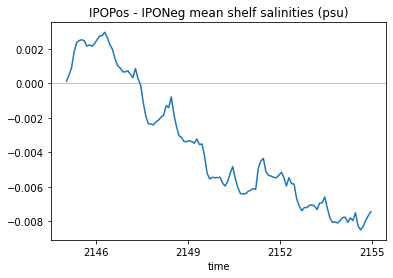

In [68]:
%%time
((data_Pos-data_Neg)*above1000_tcells).mean(['st_ocean', 'yt_ocean', 'xt_ocean']).plot()
plt.axhline(0, color='grey', lw=.5)
plt.title('IPOPos - IPONeg mean shelf salinities (psu)')
# Wall time: 2min

In [5]:
# next step, change tcell latitude to other axis so I can add the contour to the plot

In [43]:
field

<xarray.DataArray 'hu' (yu_ocean: 2700, xu_ocean: 3600)>
dask.array<open_dataset-e2ff7fd54416960a24635239802efe7dhu, shape=(2700, 3600), dtype=float32, chunksize=(2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
    geolon_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point

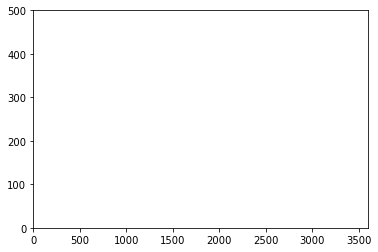

In [15]:
field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath

In [21]:
data_anom

<xarray.DataArray (time: 120, xt_ocean: 3600)>
dask.array<mean_agg-aggregate, shape=(120, 3600), dtype=float32, chunksize=(3, 450), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * time      (time) object 2145-01-16 12:00:00 ... 2154-12-16 12:00:00

ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._subplots.AxesSubplot'>

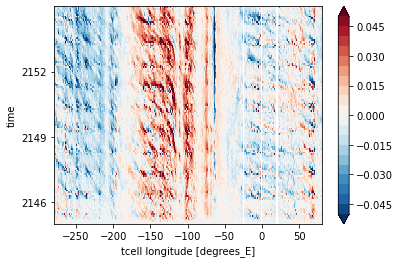

In [20]:
%%time
data_anom.plot(cmap='RdBu_r', levels=ticks)
field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath